<a href="https://colab.research.google.com/github/Onyimatics/diabetes_prediction_deep_neural_network/blob/master/Best_Model_Diabetes_Prediction_With_Deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.4 MB/s eta 0:00:00


In [ ]:
## Importing the libraries needed for collecting data and for analysis
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from scipy import stats

import numpy as np
import pandas as pd
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# build the neural network using keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Nadam, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.initializers import HeUniform
from sklearn.metrics import classification_report, confusion_matrix
import random
import os

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)

In [ ]:
# Load datasets
train_df = pd.read_csv('https://drive.google.com/uc?export=download&id=1M4MTBKUaR4aA8hjINEGhfShBZ18ctZA-')
test_df = pd.read_csv('https://drive.google.com/uc?export=download&id=1BhfC5yBThGkAdkxbf7kEVZFjsysVYXqP')

In [ ]:
train_df.head()

,id,A1,A2,A3,A4,A5,A6,A7,A8,class
0,1,6,148,72,35,0,33.6,0.627,50,1
1,2,1,85,66,29,0,26.6,0.351,31,0
2,3,8,183,64,0,0,23.3,0.672,32,1
3,4,1,89,66,23,94,28.1,0.167,21,0
4,5,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
train_df.isnull().sum()

,0
id,0
A1,0
A2,0
A3,0
A4,0
A5,0
A6,0
A7,0
A8,0
class,0


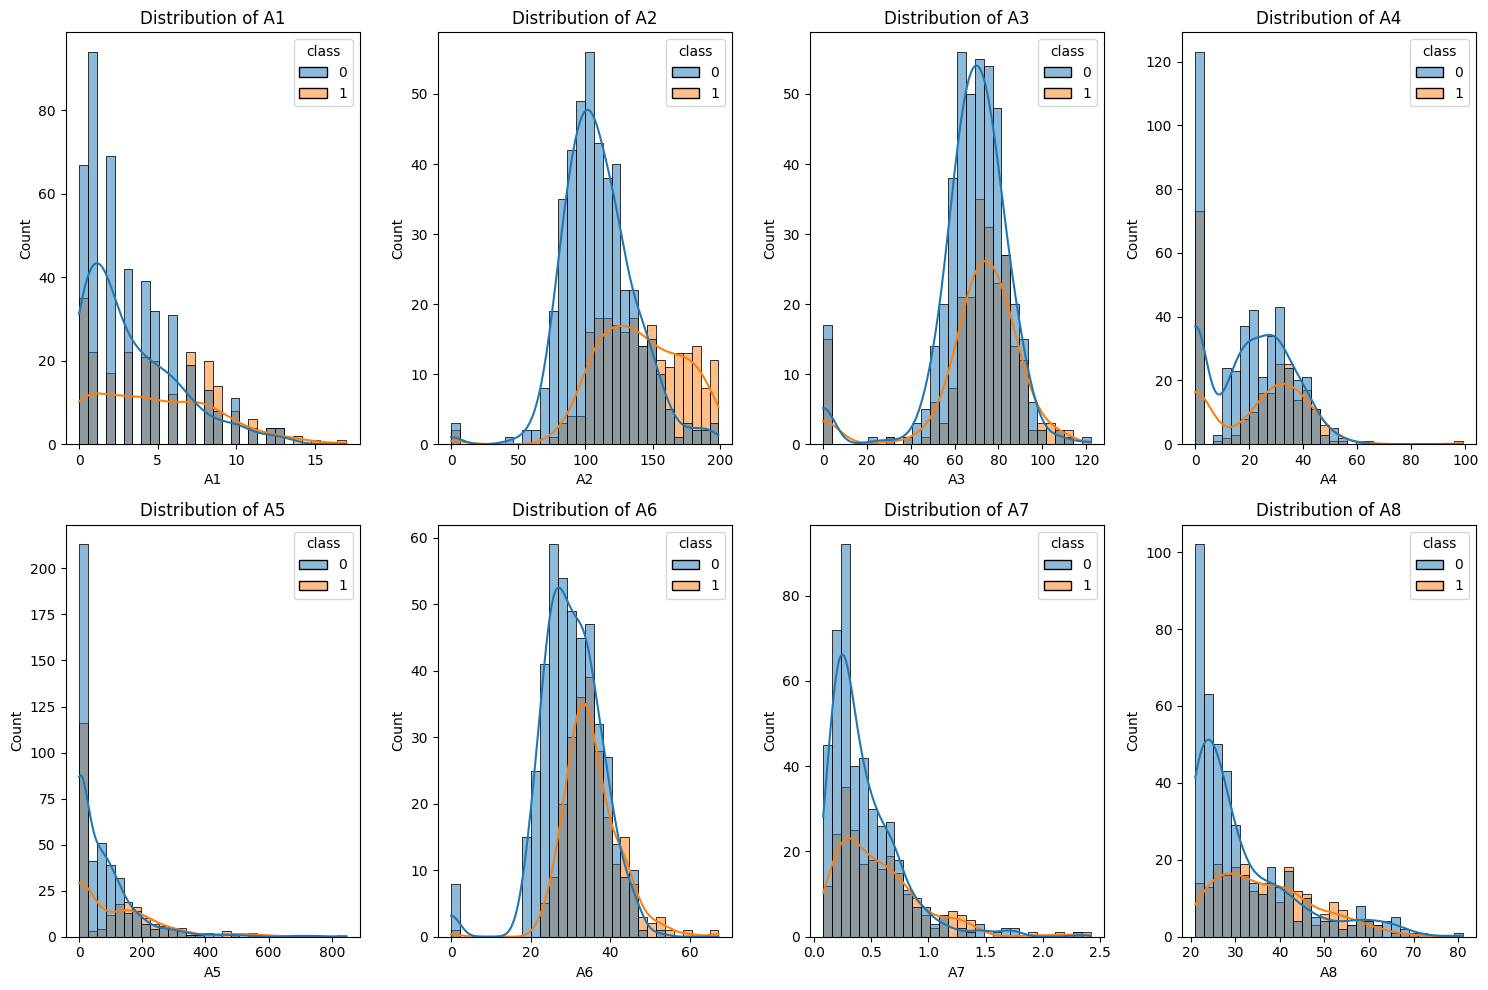

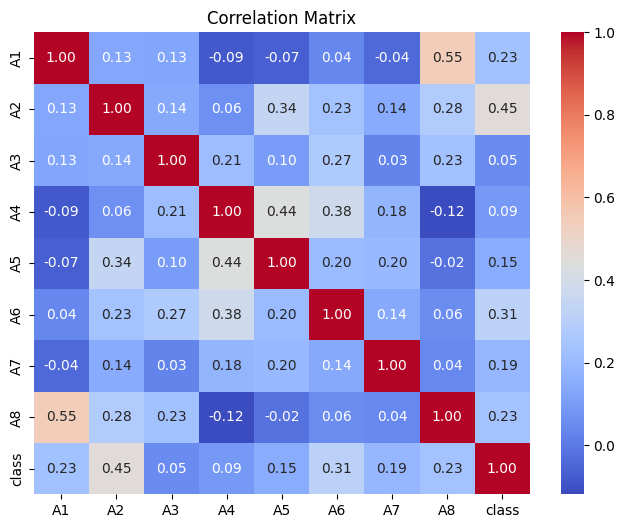

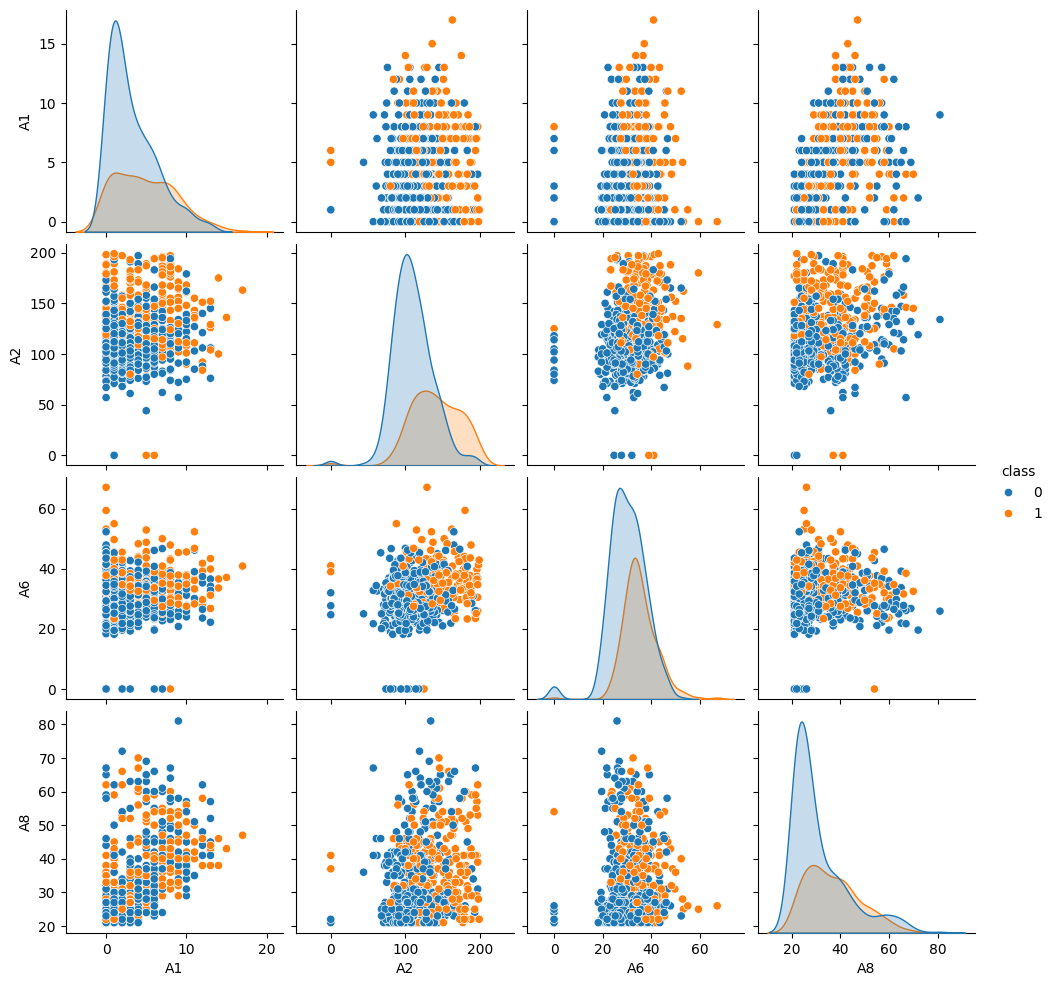

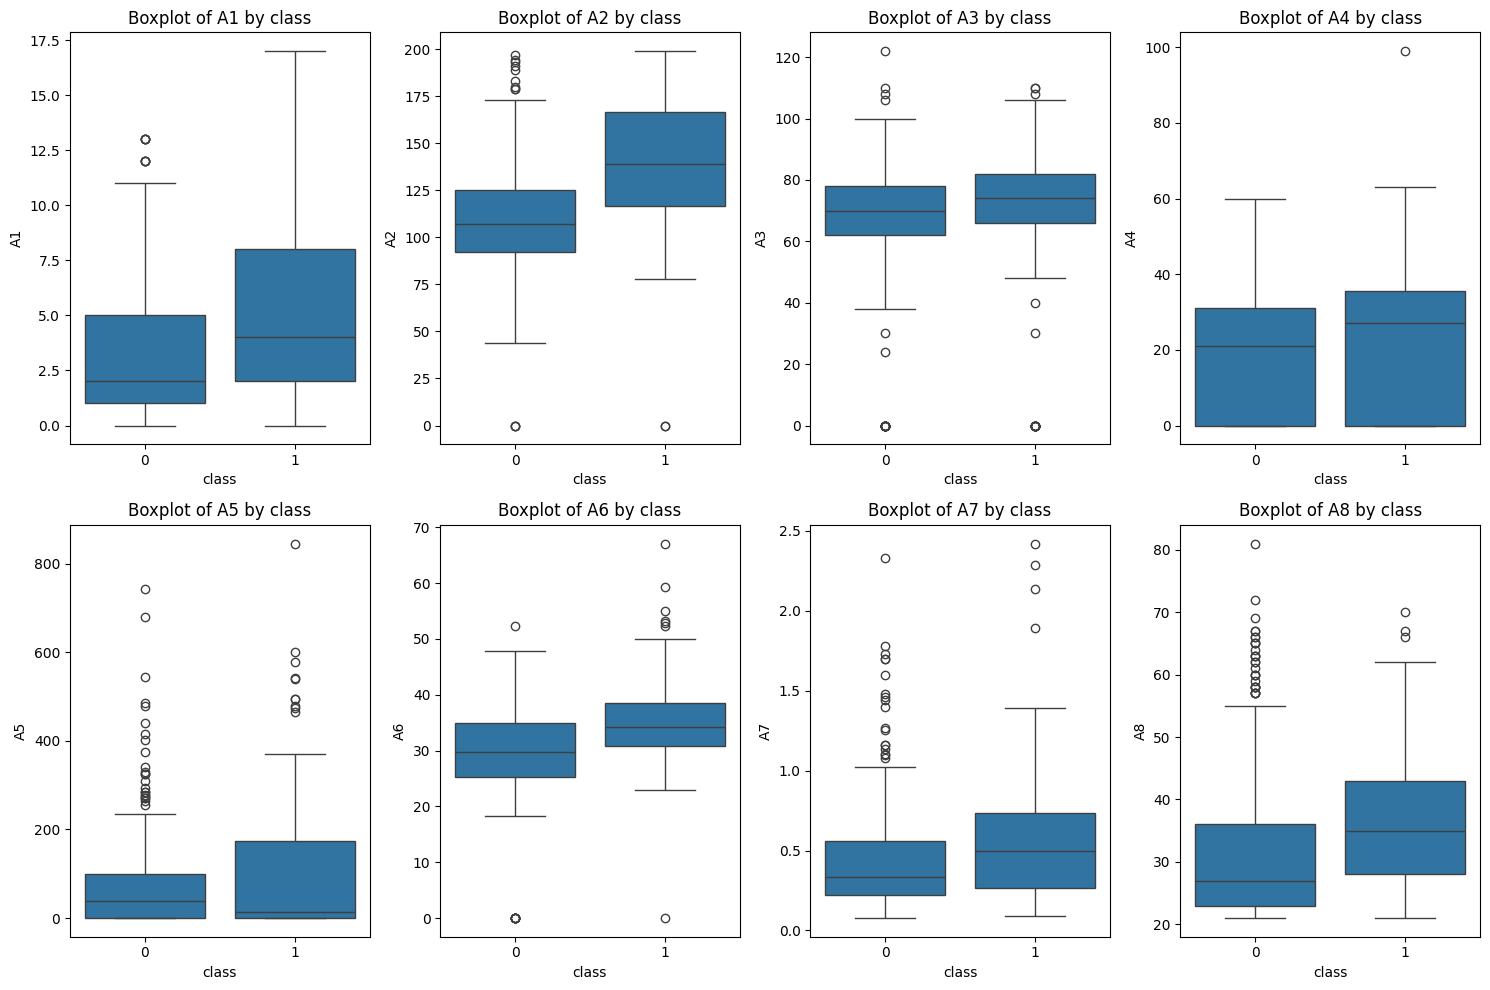

In [ ]:
# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Histograms for each feature
for i, column in enumerate(['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8']):
    plt.subplot(2, 4, i+1)
    sns.histplot(data=train_df, x=column, hue='class', kde=True, bins=30)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(8, 6))
correlation_matrix = train_df.drop('id', axis=1).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Pairplot for key features
sns.pairplot(train_df[['A1', 'A2', 'A6', 'A8', 'class']], hue='class')
plt.show()

# Box plots to check for outliers
plt.figure(figsize=(15, 10))
for i, column in enumerate(['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8']):
    plt.subplot(2, 4, i+1)
    sns.boxplot(data=train_df, y=column, x='class')
    plt.title(f'Boxplot of {column} by class')
plt.tight_layout()
plt.show()

In [ ]:
def replace_with_median(df, value, value_at='class'):
    """Replaces zeros in a column with the median value based on class,
       or with the overall median if 'class' column is not present."""

    # Check if 'class' column exists
    if value_at in df.columns:
        # Calculate median for each class (excluding zeros)
        class_medians = df.loc[df[value] != 0, [value, value_at]].groupby(value_at)[value].median()

        # Replace zeros with class-specific medians
        for class_val, median_val in class_medians.items():
            df.loc[(df[value] == 0) & (df[value_at] == class_val), value] = median_val
    else:
        # If 'class' column is not present, use overall median (excluding zeros)
        median_val = df.loc[df[value] != 0, value].median()
        df.loc[df[value] == 0, value] = median_val

    return df

# Run the function for specified columns
for col in ['A2', 'A3', 'A4', 'A5', 'A6']:
    replace_with_median(train_df, col, 'class')
    replace_with_median(test_df, col)

<ipython-input-204-8221b421c82d>:30: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '121.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

<ipython-input-204-8221b421c82d>:30: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '152.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



In [ ]:
train_df.head()

,id,A1,A2,A3,A4,A5,A6,A7,A8,class
0,1,6,148,72,35,173,33.6,0.627,50,1
1,2,1,85,66,29,94,26.6,0.351,31,0
2,3,8,183,64,32,173,23.3,0.672,32,1
3,4,1,89,66,23,94,28.1,0.167,21,0
4,5,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
X = train_df.drop(['id', 'class'], axis=1)
y = train_df['class']

In [ ]:
from sklearn.preprocessing import PowerTransformer, RobustScaler

# power_transformer = PowerTransformer(method='yeo-johnson')
# X_scaled = power_transformer.fit_transform(X)
# X_test_scaled = power_transformer.transform(X_test)

In [ ]:
#split into training (80%) and remaining (20%) datasets
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  stratify=y,
                                                  random_state=SEED)

In [ ]:
test_df.head()

,id,A1,A2,A3,A4,A5,A6,A7,A8
0,1,6,98.0,58,33,190.0,34.0,0.430,43
1,2,9,154.0,78,30,100.0,30.9,0.164,45
2,3,6,165.0,68,26,168.0,33.6,0.631,49
3,4,1,99.0,58,10,152.5,25.4,0.551,21
4,5,10,68.0,106,23,49.0,35.5,0.285,47


In [ ]:
# Create a StandardScaler object
ss = StandardScaler()

# Fit the scaler on the training data and transform both training and validation data
X_train_scaled = ss.fit_transform(X_train)
X_val_scaled = ss.transform(X_val)
X_test_scaled = ss.transform(test_df.drop('id', axis=1))

In [ ]:
# Clear session to free memory
keras.backend.clear_session()

# set random seed
# keras.utils.set_random_seed(SEED) # set all random seeds for the program (Python, NumPy, and TensorFlow)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 16)                  │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 561 (2.19 KB)

 Trainable params: 497 (1.94 KB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.5181 - loss: 0.8251 - val_accuracy: 0.7239 - val_loss: 0.5110
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7875 - loss: 0.4829 - val_accuracy: 0.7388 - val_loss: 0.4926
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8115 - loss: 0.4523 - val_accuracy: 0.7836 - val_loss: 0.4617
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8119 - loss: 0.4340 - val_accuracy: 0.8134 - val_loss: 0.4695
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8242 - loss: 0.3953 - val_accuracy: 0.8358 - val_loss: 0.4612
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8103 - loss: 0.4216 - val_accuracy: 0.8358 - val_loss: 0.4501
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8022 - loss: 0.4597 - val_accuracy: 0.8433 - val_loss: 0.4451
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8119 - loss: 0.4175 - val_accuracy: 0.8284 - 

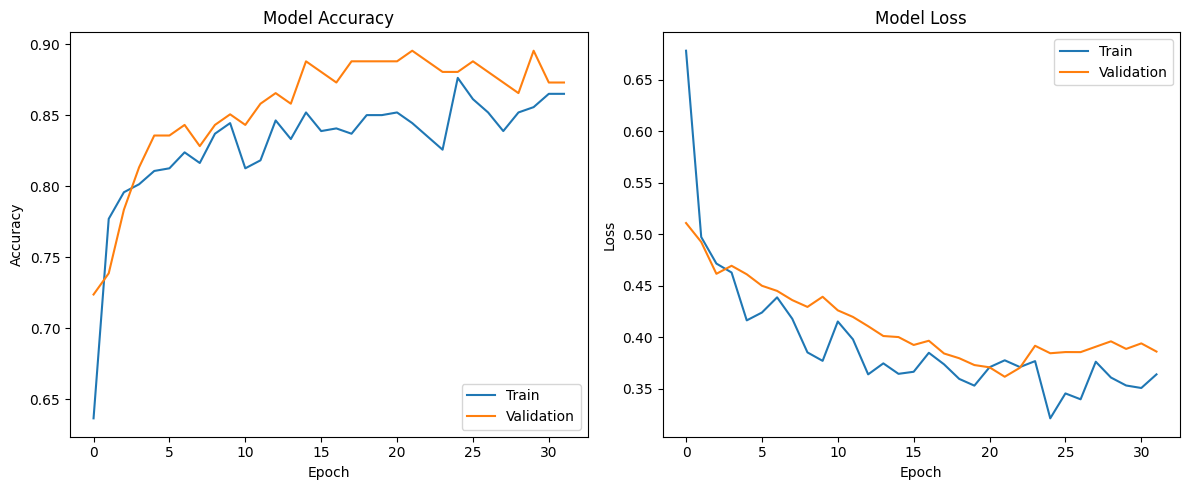

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


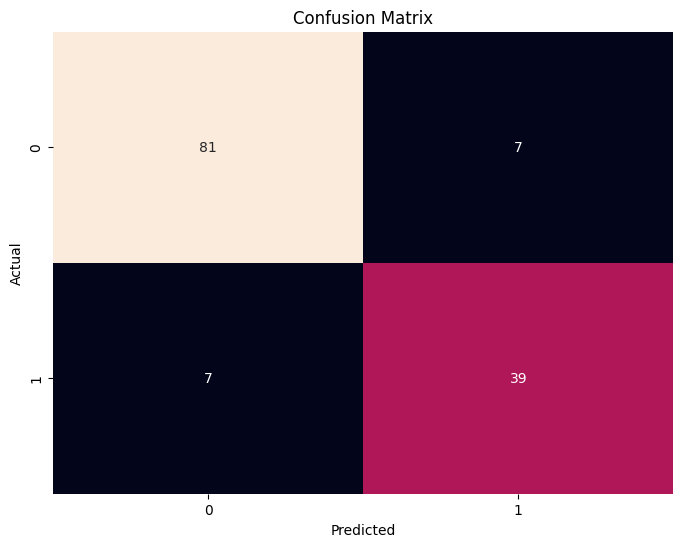


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        88
           1       0.85      0.85      0.85        46

    accuracy                           0.90       134
   macro avg       0.88      0.88      0.88       134
weighted avg       0.90      0.90      0.90       134



In [ ]:
# Replace existing model code with this improved version
def create_best_model(input_dim):
    """Create the neural network with exact hyperparameters that achieved high accuracy"""

    # Initialize with a kernel initializer
    initializer = HeUniform(seed=SEED)

    model = Sequential()

    model.add(Dense(16, input_dim=input_dim,
                   activation='relu',
                   kernel_initializer=initializer,
                    kernel_regularizer=l1_l2(l1=4.4305e-05, l2=4.4305e-05)
                   ))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(16,
                   activation='relu',
                   kernel_initializer=initializer,
                   kernel_regularizer=l1_l2(l1=6.68e-05, l2=6.68e-05)
                   ))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=0.008)

    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )

    return model

# Create the model with the best hyperparameters
best_model = create_best_model(X_train_scaled.shape[1])
best_model.summary()

# Define better callbacks
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
]

# Train with more epochs
history = best_model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_val_scaled, y_val),
    callbacks=callbacks,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.show()

# Get predictions for confusion matrix
y_pred_proba = best_model.predict(X_val_scaled)
y_pred = (y_pred_proba > 0.5).astype(int)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

In [ ]:
import pandas as pd
import plotly.express as px

df = pd.DataFrame({
    "Train Accuracy": history.history["accuracy"],
    "Test Accuracy": history.history["val_accuracy"]
})

fig = px.line(df,
              x=df.index,
              y=["Train Accuracy", "Test Accuracy"],
              template="plotly_dark",
              labels={"value": "Accuracy", "index": "Epoch", "variable": "Metric"},
              color_discrete_sequence=['#3D89BD','#FF9A45'],
              width=1000, height=500
              )
fig.update_layout(
    title_font_color="#41BEE9",
    xaxis=dict(color="#41BEE9",title='Epochs'),
    yaxis=dict(color="#41BEE9")
 )
fig.show()

loss_df = pd.DataFrame({
    "Train Loss": history.history["loss"],
    "Test Loss": history.history["val_loss"]
})


fig = px.line(loss_df,
              x=loss_df.index,
              y=["Train Loss", "Test Loss"],
              template="plotly_dark",
              labels={"value": "Loss", "index": "Epoch", "variable": "Metric"},
              color_discrete_sequence=['#3D89BD','#FF9A45'],
              width=1000, height=500
              )
fig.update_layout(
    title_font_color="#41BEE9",
    xaxis=dict(color="#41BEE9",title='Epochs'),
    yaxis=dict(color="#41BEE9")
 )
fig.show()

In [ ]:
# # Extract the features by dropping the 'id' column
# X_test = test_df.drop(['id'], axis=1)

# # Apply the same scaler used during training
# X_test_scaled = ss.transform(X_test)

# Use the trained model to predict probabilities on the test data
predictions = best_model.predict(X_test_scaled)

# Convert probabilities to binary predictions using a threshold of 0.5
final_predictions = (predictions > 0.5).astype(int).flatten()

# Create a submission DataFrame with the id and predictions
submission = pd.DataFrame({'id': test_df['id'], 'prediction': final_predictions})

# Save the predictions to a CSV file
submission.to_csv('test-predictions.csv', index=False)
print("Test predictions saved to 'test-predictions.csv'")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Test predictions saved to 'test-predictions.csv'


In [ ]:
from tensorflow.keras import backend as K

# Clear session to free memory
keras.backend.clear_session()

# set random seed
keras.utils.set_random_seed(SEED) # set all random seeds for the program (Python, NumPy, and TensorFlow)